In [1]:
import numpy as np
import cv2 
import os 
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [2]:
import pathlib
data_dir=pathlib.Path('data')

In [3]:
def laod_images_opencv_extisions(path):
    ext = [".jpg",".gif",".png",".tga",".webp"]   # Add image formats here
    files = []
    images = []
    [files.extend(data_dir.glob(path + '/*' + e)) for e in ext]
    return files

In [4]:
image_files=laod_images_opencv_extisions('Train')
image_files[:5]

[WindowsPath('data/Train/Basketball_1.jpg'),
 WindowsPath('data/Train/Basketball_10.jpg'),
 WindowsPath('data/Train/Basketball_100.jpg'),
 WindowsPath('data/Train/Basketball_101.jpg'),
 WindowsPath('data/Train/Basketball_102.jpg')]

In [5]:
X,Y=[],[]
for i in image_files:
  la=str(i).split('\\')[-1].split('_')[0]
  X.append(i)
  Y.append(la)

In [6]:
import pandas as pd
dataFrame = pd.DataFrame({
    'filename': X,
    'category': Y
})
dataFrame['category'] = dataFrame['category'].astype('string')
dataFrame['filename'] = dataFrame['filename'].astype('string')
dataFrame.head()

,filename,category
0,data\Train\Basketball_1.jpg,Basketball
1,data\Train\Basketball_10.jpg,Basketball
2,data\Train\Basketball_100.jpg,Basketball
3,data\Train\Basketball_101.jpg,Basketball
4,data\Train\Basketball_102.jpg,Basketball


In [7]:
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
dataFrame['category'] = le.fit_transform(dataFrame['category'])
dataFrame['category'] = dataFrame['category'].astype('string')

In [8]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(dataFrame,random_state=158,test_size=.2)

train_df = dataFrame.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [9]:
image_size = 224
input_shape = (image_size, image_size, 3)

batch_size = 8

In [10]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filename',
    y_col='category',

    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 1681 validated image filenames belonging to 6 classes.


Found 1 validated image filenames belonging to 1 classes.


C:\Users\Mahmoud S.AbdelRahma\AppData\Local\Temp\ipykernel_7048\3995389263.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


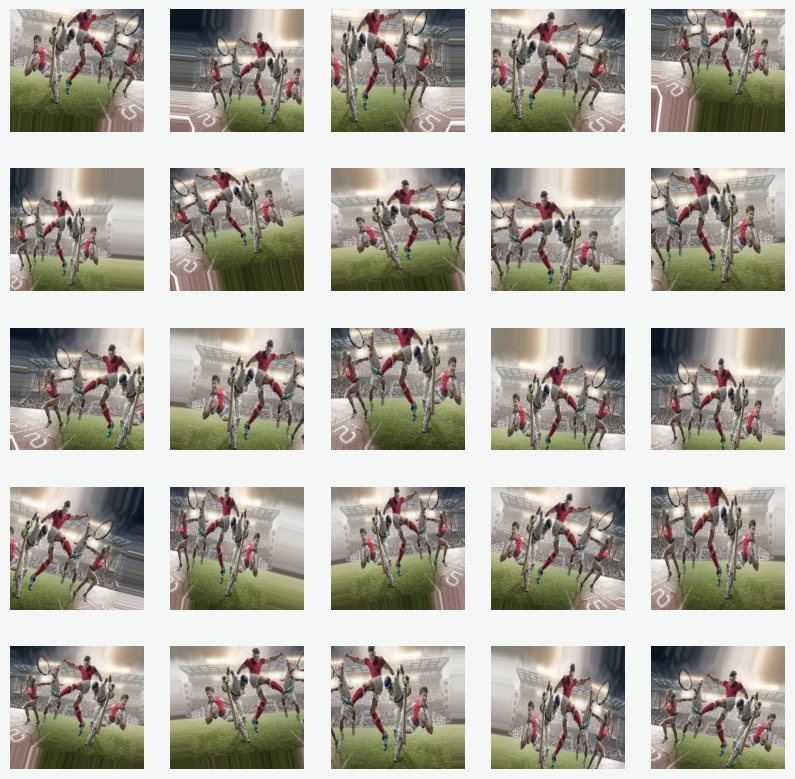

In [11]:
import matplotlib.pyplot as plt
def data_argumentation_show(n, grid_size):
    sample_data = train_datagen.flow_from_dataframe(
            (train_df.sample(n)),
            x_col = 'filename',
            y_col = 'category',
            target_size = (224, 244),
            class_mode = 'categorical')
  
    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
            plt.tight_layout()
            del img
    fig.show()
data_argumentation_show(1,5)

In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
     
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 337 validated image filenames belonging to 6 classes.


In [13]:
from tensorflow.keras.optimizers import SGD
from keras.layers  import Input
from keras.layers.pooling import AveragePooling2D
from keras.layers.core import Flatten,Dense,Dropout
from keras.models import Model

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

def myCallbacks(weights_name):
    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_accuracy', 
        patience=2, 
        verbose=1, 
        factor=0.2, 
        min_lr=0.0001,
        )
    es=EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01,
        patience=8,
        verbose=1,
        mode="auto",
    )
    model_cp=ModelCheckpoint(
        filepath=str(weights_name)+".h5",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    callbacks = [es,model_cp, learning_rate_reduction]
    return callbacks

In [15]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

def create_model():
 
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(6, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  
  return model



In [16]:
import warnings
warnings.filterwarnings("ignore")

custome_model=create_model()
custome_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [17]:
history = custome_model.fit_generator(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=myCallbacks('custome_model')
)

Epoch 1/5
210/210 [==============================] - ETA: 0s - loss: 1.2675 - accuracy: 0.5117
Epoch 1: val_accuracy improved from -inf to 0.63690, saving model to custome_model.h5
210/210 [==============================] - 31s 135ms/step - loss: 1.2675 - accuracy: 0.5117 - val_loss: 1.0251 - val_accuracy: 0.6369 - lr: 1.0000e-04
Epoch 2/5
210/210 [==============================] - ETA: 0s - loss: 1.0390 - accuracy: 0.6228
Epoch 2: val_accuracy did not improve from 0.63690
210/210 [==============================] - 20s 93ms/step - loss: 1.0390 - accuracy: 0.6228 - val_loss: 1.0386 - val_accuracy: 0.6339 - lr: 1.0000e-04
Epoch 3/5
210/210 [==============================] - ETA: 0s - loss: 0.9291 - accuracy: 0.6545
Epoch 3: val_accuracy improved from 0.63690 to 0.66964, saving model to custome_model.h5
210/210 [==============================] - 20s 96ms/step - loss: 0.9291 - accuracy: 0.6545 - val_loss: 0.8735 - val_accuracy: 0.6696 - lr: 1.0000e-04
Epoch 4/5
210/210 [===================

In [18]:
from tensorflow.keras import optimizers
epochs=25

model = Sequential([
  layers.Conv2D(64,3,input_shape=(224,224,3),padding="same", activation="relu",name='block1_conv1'),
  layers.Conv2D(64, 3, padding='same', activation='relu',name='block1_conv2'),
  layers.MaxPooling2D(name='block1_pool'),

  layers.Conv2D(128, 3, padding='same', activation='relu',name='block2_conv1'),
  layers.Conv2D(128, 3, padding='same', activation='relu',name='block2_conv2'),
  layers.MaxPooling2D(name='block2_pool'),

  layers.Conv2D(256, 3, padding='same', activation='relu',name='block3_conv1'),
  layers.Conv2D(256, 3, padding='same', activation='relu',name='block3_conv2'),
  layers.Conv2D(256, 3, padding='same', activation='relu',name='block3_conv3'),
  layers.MaxPooling2D(name='block3_pool'),

  layers.Conv2D(512, 3, padding='same', activation='relu',name='block4_conv1'),
  layers.Conv2D(512, 3, padding='same', activation='relu',name='block4_conv2'),
  layers.Conv2D(512, 3, padding='same', activation='relu',name='block4_conv3'),
  layers.MaxPooling2D(name='block4_pool'),

  layers.Conv2D(512, 3, padding='same', activation='relu',name='block5_conv1'),
  layers.Conv2D(512, 3, padding='same', activation='relu',name='block5_conv2'),
  layers.Conv2D(512, 3, padding='same', activation='relu',name='block5_conv3'),
  layers.MaxPooling2D(name='block5_pool'),
  
  layers.GlobalMaxPooling2D(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.7),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.7),

  layers.Dense(6,activation='softmax'),
])

model.load_weights('weights\model_vgg16_last.h5')
for layer in model.layers[:14]:
    layer.trainable = False

for layer in model.layers[14:]:
    layer.trainable = True

opt=keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,decay=1e-4//epochs)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [19]:
history1 = model.fit_generator(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=myCallbacks('model_vgg'),
)

Epoch 1/5
210/210 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9940
Epoch 1: val_accuracy improved from -inf to 0.99405, saving model to model_vgg.h5
210/210 [==============================] - 36s 150ms/step - loss: 0.0327 - accuracy: 0.9940 - val_loss: 0.0070 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 2/5
210/210 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9928
Epoch 2: val_accuracy improved from 0.99405 to 0.99702, saving model to model_vgg.h5
210/210 [==============================] - 30s 144ms/step - loss: 0.0231 - accuracy: 0.9928 - val_loss: 0.0062 - val_accuracy: 0.9970 - lr: 0.0010
Epoch 3/5
210/210 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9946
Epoch 3: val_accuracy did not improve from 0.99702
210/210 [==============================] - 30s 141ms/step - loss: 0.0148 - accuracy: 0.9946 - val_loss: 0.0169 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 4/5
210/210 [==============================] - ETA

In [20]:
test_filenames = os.listdir("data\Test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [21]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data\Test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 688 validated image filenames.


In [22]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [23]:
pred = [np.argmax(pred) for pred in predict]

In [24]:
Submission = pd.DataFrame({
    'image_name': test_filenames,
    'label': pred
})
Submission.head()

,image_name,label
0,0.jpg,4
1,1.jpg,4
2,10.jpg,5
3,100.jpg,5
4,101.jpg,1


In [25]:
Submission.to_csv("Submission11.csv")

In [29]:
model.load_weights('weights\model_vgg16_last.h5')

In [30]:
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(image_path):
    path = image_path
    img = cv2.imread(path)
    imre=cv2.resize(img,(224,224))
    imre=imre/255.0
    x = np.expand_dims(imre, axis=0)
    label = np.argmax(model.predict([x]))
    print(f"class of the image is : {le.classes_[label]}")
    plt.imshow(img) 


1/1 [==============================] - 0s 23ms/step
class of the image is : Football


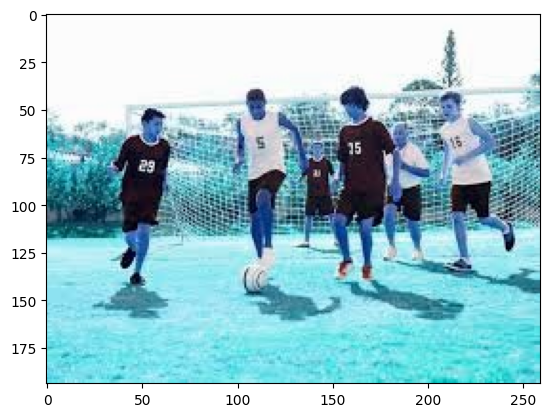

In [31]:
predict_image(r'data\Test\119.jpg')

1/1 [==============================] - 0s 27ms/step
class of the image is : Football


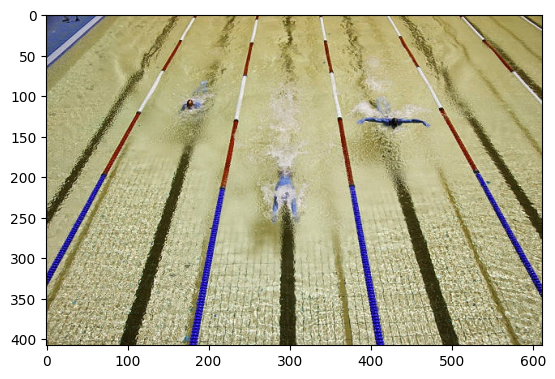

In [32]:
predict_image(r'data\Test\121.jpg')